#### Import Relevant Python Packages

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
# Single Column Plot (as per NRC CJCE specs)
def set_size_onecol(fig):
    fig.set_size_inches(9.3, 3.4)
def set_size_twocol(fig):
    fig.set_size_inches(9.3, 7.2)
#plt.rcParams['grid.color'] = 'k'
#plt.rcParams['grid.linestyle'] = ':'
#plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'large'

# Mono-Symmetry of Standard WT-Shapes for LTB

In [10]:
# Input desired filename
filename = 'c:/jk/ualberta/Courses/project_DRA/analysis/CISC_StructuralSectionTables/CISC_SST_ver92_WT-cleaned.csv'
(path,file) = os.path.split(filename)

In [11]:
# Load section properties CSV file (W-Shapes)
dfall = pd.read_csv(filename)

## Additional Section Property Calculatons

*!!!ASSUMING THAT THE DATUM IS THE CENTROID OF THE TOP FLANGE!!!*

Determine the distance between flange centroids.

In [12]:
dfall['d_prime'] = dfall['D'] - dfall['T']/2

Determine centroid of T-section.

In [13]:
dfall['yT_bar'] = dfall['T']/2 + dfall['Yo'] 

Determine major over minor moment of inertia ratio.

In [14]:
dfall['Iy/Ix'] = dfall['Iy']/dfall['Ix']

In [15]:
Fy = 350 #MPa

In [16]:
dfall['Flange Criteria'] = ((dfall['B']/2)/dfall['T'])*np.sqrt(Fy)
crit1 = 145
crit2 = 170
crit3 = 200
dfall['Flange Class'] = np.where(dfall['Flange Criteria'] < crit1, 1, np.where(dfall['Flange Criteria'] < crit2, 2, np.where(dfall['Flange Criteria'] < crit3, 3, 4)))

In [17]:
dfall['Section Class'] = dfall['Flange Class']

## Determine exact $\beta_x$ value

In [18]:
dfall['term1'] = (1/dfall['Ix'])
dfall['term2'] = (dfall['W']/4)*((dfall['D'] - dfall['yT_bar'])**4 - (dfall['yT_bar'] - dfall['T']/2)**4)
dfall['term3'] = dfall['B']*dfall['T']*(dfall['yT_bar'] - dfall['T']/2)*(dfall['B']**2/12 + (dfall['yT_bar'] - dfall['T']/2)**2)
dfall['term4'] = -2*dfall['Yo']
dfall['BetX_calc'] = (dfall['term2'] - dfall['term3'])/dfall['Ix'] - dfall['term4']

### Determine % difference of calculating $\beta_x$ with and without including fillet areas of 3 plate I-sections.

In [19]:
dfall['% Difference with/without Including Fillets'] = (np.absolute(dfall['BetX_calc'] - dfall['BetX'])/dfall['BetX'])*100

## Determine approx. $\beta_x$ value

In [20]:
dfall['Iy_Flange1'] = ((dfall['B']**3)*dfall['T'])/12
dfall['BetX_S16'] = 0.9*(dfall['D'] - dfall['T'])*((2*dfall['Iy_Flange1'])/dfall['Iy'] - 1)*(1 - (dfall['Iy']/dfall['Ix'])**2)
rho = 1
dfall['BetX_K&T'] = 0.9*(dfall['D'] - dfall['T'])*(2*rho - 1)*(1 - (dfall['Iy']/dfall['Ix'])**2)

## Determine % Error of $\beta_x$ Approx. w.r.t. Exact value

In [21]:
dfall['Percent Error S16-14'] = ((dfall['BetX_S16'] - (dfall['BetX']))/np.absolute(dfall['BetX']))*100
dfall['Percent Error K&T'] = ((dfall['BetX_K&T'] - (dfall['BetX']))/np.absolute(dfall['BetX']))*100

In [15]:
dfall.to_csv('Handbook-Vs-Galambo_T-Section_BetX_Comparison.csv')

## Determine Number of Sections per Class

In [22]:
c123 = len(dfall[dfall['Section Class'] != 4])
c4 = len(dfall[dfall['Section Class'] == 4])
print('The number of Class 1, 2, and 3 sections are: %d' % c123) 
print('The number of Class 4 sections is: %d' % c4)
print('Percentage of Class 4 Sections: %.2f' % ((c4/c123)*100))

The number of Class 1, 2, and 3 sections are: 187
The number of Class 4 sections is: 1
Percentage of Class 4 Sections: 0.53


In [23]:
print(max(dfall['Percent Error K&T']))
print(max(dfall['Percent Error S16-14']))
print(min(dfall['Percent Error K&T']))
print(min(dfall['Percent Error S16-14']))

12.62654279465022
12.11770360156539
-14405.482222803565
-14442.93108034731


In [24]:
print(min(dfall[dfall['Iy/Ix'] < 0.5]['Percent Error K&T']))
print(min(dfall[dfall['Iy/Ix'] < 0.5]['Percent Error S16-14']))

-2.84619620669415
-3.1446717943848


In [25]:
print(max(dfall[dfall['Iy/Ix'] < 0.5]['Percent Error K&T']))
print(max(dfall[dfall['Iy/Ix'] < 0.5]['Percent Error S16-14']))

12.62654279465022
12.11770360156539


## Plotting the % Error for All WT-Shapes

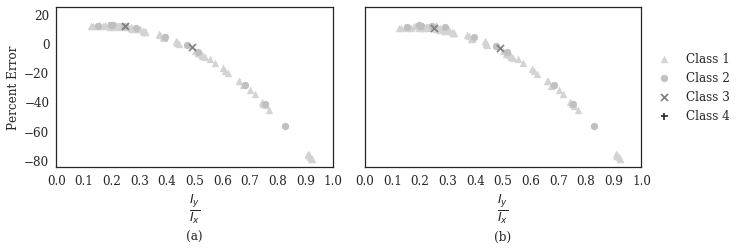

In [46]:
# Set Figure style
set_style()
# Compute Figure 4
fig4, ax4 = plt.subplots(nrows=1, ncols=2, sharey='row')
mkr_dict_def = {1: 'Class 1', 2: 'Class 2', 3: 'Class 3', 4: 'Class 4'}
mkr_dict = {1: '^', 2: 'o', 3: 'x', 4: '+'}
color = {1: '#D3D3D3', 2: '#C0C0C0', 3: '#808080', 4: '#303030'}
for kind in mkr_dict:
    dd1 = dfall[dfall['Section Class'] == kind]
    dd2 = dd1[dd1['Iy/Ix'] < 1.0]
    ax4[0].scatter(dd2['Iy/Ix'], dd2['Percent Error K&T'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax4[0].tick_params(axis='both', which='major', labelsize=12)
    ax4[1].scatter(dd2['Iy/Ix'], dd2['Percent Error S16-14'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax4[1].tick_params(axis='both', which='major', labelsize=12)
    # ax4[1,0].scatter(dd2['Iy/Ix'], dd2['Percent Error K&T'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    # ax4[1,0].tick_params(axis='both', which='major', labelsize=12)
    # ax4[1,1].scatter(dd2['Iy/Ix'], dd2['Percent Error S16-14'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    # ax4[1,1].tick_params(axis='both', which='major', labelsize=12)
# Set the y-axis label only for the left subplot
ax4.flat[0].set_ylabel('Percent Error', fontsize='12')
# ax4.flat[2].set_ylabel('Percent Error', fontsize='12')
ax4.flat[0].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
ax4.flat[1].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
# ax4.flat[2].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
# ax4.flat[3].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
# Set x and y limits
ax4.flat[0].set_ylim((-85,25))
ax4.flat[0].set_xticks((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0))
ax4.flat[1].set_xticks((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0))
# ax4.flat[2].set_xticks((0,0.1,0.2,0.3,0.4,0.5,0.6))
# ax4.flat[3].set_xticks((0,0.1,0.2,0.3,0.4,0.5,0.6))
# Set the labels for each column
ax4.flat[0].text(0.5,-0.45, "(a)", size=12, ha="center", transform=ax4.flat[0].transAxes)
ax4.flat[1].text(0.5,-0.45, "(b)", size=12, ha="center", transform=ax4.flat[1].transAxes)
# Create Legend
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='12')
# Set size as per CJCE requirements
set_size_onecol(fig4)
# Set up tight plot layout
plt.tight_layout()
# Save the figure
plt.savefig('./paper_figs/Figure4.png', bbox_inches="tight")
plt.savefig('./paper_figs/Figure4.pdf', bbox_inches="tight")
plt.savefig('./paper_figs/Figure4.svg', bbox_inches="tight")

In [26]:
dfallwCapacity = pd.DataFrame()
E = 200000 #MPa
G = 77000 #MPa
L = 10000 #mm, Assuming a 10m long beam... discussion?
w2 = 1 #Assuming uniform bending (can generalize later...)
for index,row in dfall.iterrows():
    if row['BetX_calc'] >= 0:
        row['Mo_(cr)_exact'] = ((np.pi**2*E*row['Iy']*row['BetX_calc'])/(2*L**2))*(1 + np.sqrt(1 + (4/row['BetX_calc']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))
    else:
        row['Mo_(cr)_exact'] = ((np.pi**2*E*row['Iy']*row['BetX_calc'])/(2*L**2))*(1 - np.sqrt(1 + (4/row['BetX_calc']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))                
    if row['BetX_S16'] >= 0:
        row['Mo_(cr)_S16'] = ((np.pi**2*E*row['Iy']*row['BetX_S16'])/(2*L**2))*(1 + np.sqrt(1 + (4/row['BetX_S16']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))
    else:
        row['Mo_(cr)_S16'] = ((np.pi**2*E*row['Iy']*row['BetX_S16'])/(2*L**2))*(1 - np.sqrt(1 + (4/row['BetX_S16']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))
    # Append to new dataframe
    dfallwCapacity = dfallwCapacity.append(row)

In [27]:
dfallwCapacity['Percent Error of BetX Effect on Moment'] = ((dfallwCapacity['Mo_(cr)_S16'] - dfallwCapacity['Mo_(cr)_exact'])/np.absolute(dfallwCapacity['Mo_(cr)_exact']))*100

In [29]:
dfallwCapacity.to_csv('Handbook-Vs-Galambo_T-Section_BetX_Comparison_withMomentCapacity.csv')